In [1]:
import scipy.io
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import time as ktime

<h2>Questions to ask</h2>
<ol>
<li>what should be the length of prediciton? 1 ?</li>
<li></li>
</ol>

In [2]:
mat = scipy.io.loadmat('Data_Ankle.mat')

In [3]:
mat['ankle_data'].shape

(48000, 7)

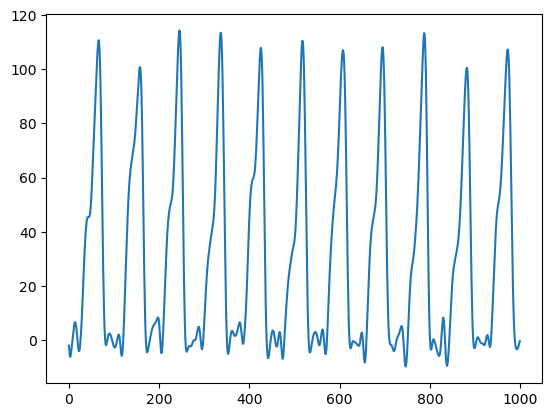

In [26]:
plt.plot(mat['ankle_data'][:1000, -1])

In [27]:
ff = np.load("fc_0_12_data.npy", allow_pickle=True).item()
ff.keys()

dict_keys(['train_loss', 'test_loss', 'val_loss', 'min_loss', 'preds', 'labels', 'errors', 'params'])

In [24]:
ff['labels'].shape

(86400,)

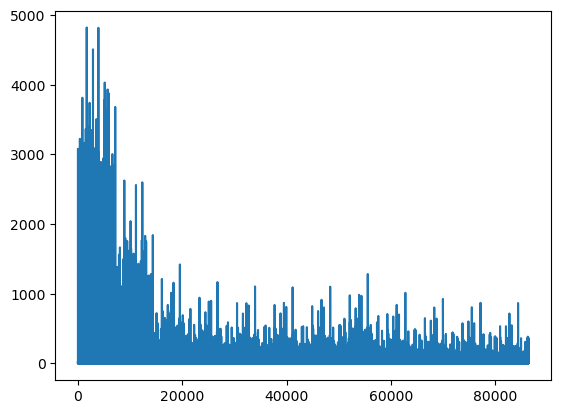

In [31]:
plt.plot(ff['errors'], label ='erors')#


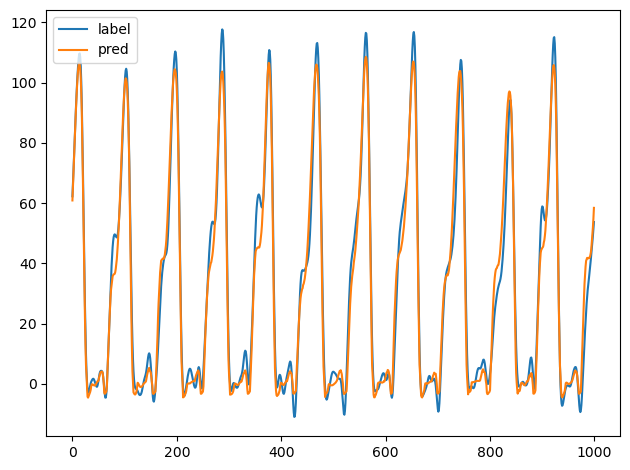

In [37]:
plt.plot(ff['labels'][-1000:], label='label')
#plt.plot(ff['errors'][:1000], label ='erors')#
plt.plot(ff['preds'][-1000:], label ='pred')#
plt.legend()
plt.tight_layout()

In [3]:
data = pd.DataFrame(mat['ankle_data'])
data.columns = ['time','ground-reaction(N)','trunk-angle(rad)','hip-angle(rad)','knee-angle(rad)','ankle-angle(rad)','joint-moment(Nm)']
data.head()

,time,ground-reaction(N),trunk-angle(rad),hip-angle(rad),knee-angle(rad),ankle-angle(rad),joint-moment(Nm)
0,0.00,-10.321381,-0.094286,0.292974,0.825063,-1.492588,-2.011628
1,0.01,-7.990312,-0.096174,0.293179,0.822469,-1.493192,-3.655209
2,0.02,-6.208738,-0.096449,0.294008,0.810997,-1.495867,-5.786433
3,0.03,-5.126637,-0.097196,0.295568,0.785731,-1.501793,-6.190008
4,0.04,-4.774037,-0.095624,0.297472,0.745707,-1.511208,-5.542868


In [4]:
data_np = mat['ankle_data'][:1000,:]
data_np.shape

(1000, 7)

In [5]:
n = len(data_np)
th = int(0.8*n)
vh = int(0.9*n)
td = data_np[:th,:]
vd = data_np[th:vh, :]
tsd = data_np[vh:,:]
print(n,th,vh,len(td),len(vd),len(tsd))

1000 800 900 800 100 100


In [31]:
td[:,:-1].shape

(38400, 6)

In [6]:
def split_sequences(seq, n_steps_in, n_steps_out):
    input_sequences, output_sequence = seq[:,:], seq[:,-1]
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
steps_in = 10
steps_out = 1
tr_d, tr_l = split_sequences(td, n_steps_in=steps_in, n_steps_out=steps_out)
print(tr_d.shape, tr_l.shape)

(791, 10, 7) (791, 1)


In [8]:
xx,yy = split_sequences(data_np, n_steps_in=10, n_steps_out=1)
xx.shape, yy.shape

((991, 10, 7), (991, 1))

In [9]:
class LeggedMotion_seq_dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels=None, transform=None):
        """
         7 different data, being time, 
         vertical ground reaction force in Newton, 
         trunk joint angle, hip joint angle,
         knee joint angle, ankle joint angle (all in radians),
         and the joint moment in Nm.
        """
        self.transform = transform
        self.data = data[:,:-1]
        self.labels = data[:,-1]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        ''' 
        data is lengthxfeat(nx6) - 
            transpose to 6xn, as we want features in channels
        '''
        three_tuple = []
        # 
        #features = torch.tensor(self.data.iloc[idx])
        features = torch.tensor(self.data[idx, :])
        labels = torch.tensor(self.labels[idx])
        #print("features:", features.shape)
        
        # 
        #return features[:,0], features[:,1], features[:,2], features[:,3], features[:,4], features[:,5], labels
        return features[0], features[1], features[2], features[3], features[4], features[5], labels
        #return (features, labels)


In [10]:
#train_data, test_data = train_test_split(xx, test_size=0.2, random_state=1)
#train_label, test_label = train_test_split(yy, test_size=0.2, random_state=1)
#train_data, train_labels= split_sequences(td, 200, 1)
#test_data, test_labels= split_sequences(tsd, 100, 1)
train_batches = torch.utils.data.DataLoader(LeggedMotion_seq_dataset(data=td), batch_size=100,  num_workers=4, shuffle=False)
test_batches = torch.utils.data.DataLoader(LeggedMotion_seq_dataset(data=vd), batch_size=100,  num_workers=4, shuffle=False)
print(f'len of trainBatches:{len(train_batches)}, testBatches-{len(test_batches)} , ')

len of trainBatches:8, testBatches-1 , 


In [11]:
count = 0
for ix,it in enumerate(train_batches):

    count += 1
    t,v,tr,h,a,f,l = it
    ii = torch.cat((v.unsqueeze(1),tr.unsqueeze(1),v.unsqueeze(1), h.unsqueeze(1)), dim=1)
    #jj = torch.cat((v.unsqueeze(2),tr.unsqueeze(2),v.unsqueeze(2), h.unsqueeze(2)), dim=2)
    #ll = torch.cat((v,tr,v,h), dim=2)
    print(ii.size(), f.unsqueeze(1).size(), a.size(), l.size())
    if count>2:
        break

torch.Size([100, 4]) torch.Size([100, 1]) torch.Size([100]) torch.Size([100])
torch.Size([100, 4]) torch.Size([100, 1]) torch.Size([100]) torch.Size([100])
torch.Size([100, 4]) torch.Size([100, 1]) torch.Size([100]) torch.Size([100])


In [12]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout=0.2):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 32) # fully connected 
        self.fc_2 = nn.Linear(32, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        #print('before:', hn.size())
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        #print('after:', hn.size())
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [13]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, ):
        super().__init__()

        self.seq = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, bias=False),
                    nn.BatchNorm1d(out_channels),
                    nn.ReLU()

                )
        
    def forward(self, input_1D):
        return self.seq(input_1D)

class CNN_time(nn.Module):
    def __init__(self, input_channels, channels=[32,64,128,256],  kernel_size=3, dropout=0.2):
        super().__init__()

        self.c1 = Conv_block(input_channels, channels[0], kernel_size=5, stride=1)
        self.c2 = Conv_block(channels[0], channels[1], kernel_size=3, stride=1)
        self.c3 = Conv_block(channels[1], channels[2], kernel_size=3)
        self.c4 = Conv_block(channels[2], channels[3], kernel_size=1)
        self.mp = nn.MaxPool1d(kernel_size=2)
        self.seq = nn.Sequential(
                    nn.Linear(256,64), nn.ReLU(),
                    nn.Linear(64,8), nn.ReLU(),
                    nn.Linear(8,1)

        )
    def forward(self, inp):
        inp = self.c1(inp)
        #
        #print("for:", inp.size())
        inp = self.c2(inp)
        #print("for2:", inp.size())
        inp = self.c3(inp)

        #print("for3:", inp.size())
        #inp = self.mp(inp)
        #inp = self.c4(inp)

        #inp = self.mp(inp)
        #print("for:", inp.size())
        # flatten
        inp = inp.reshape(inp.size()[0], -1)
        #print(inp.size())
        inp = self.seq(inp)

        return inp



In [14]:
lstm = LSTM(num_classes=1, input_size=3, hidden_size=16, num_layers=1, dropout=0)
convBlock = CNN_time(input_channels=4)

In [15]:
convBlock(torch.randn((10,4,10))).size()

torch.Size([10, 1])

In [21]:
batch_size = 50
USE_CUDA = False#torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor


In [19]:
from utils.model import FC_model

fcmodel = FC_model()

In [17]:
torch.cuda.empty_cache()

In [22]:
model = fcmodel.type(dtype)
optim = torch.optim.Adam(model.parameters(),lr=0.0001)
lss = nn.MSELoss().type(dtype)

epochs = 1000
losst = []
lossv = []
st = ktime.time()
for i in range(epochs):

    
    # fit loop
    lossTrain = 0
    lossVal = 0
    model.train()
    if USE_CUDA:
            torch.cuda.empty_cache()
    c = 0
    for idx, batches in enumerate(train_batches):
        #
        #feat, labe = batches
        time, ground_reac, trunk_j, hip_j, knee_j, ankle_j, joint_moment = batches
        # ground_reac = ground_reac.type(dtype).unsqueeze(1)
        # trunk_j = trunk_j.type(dtype).unsqueeze(1)
        # hip_j = hip_j.type(dtype).unsqueeze(1)
        # knee_j = knee_j.type(dtype).unsqueeze(1)
        # ankle_j = ankle_j.type(dtype).unsqueeze(1)
        #joint_moment = joint_moment
        #
        #print(feat.size(), labe.size())
        #print(hip_j.size(), joint_moment.size())
        optim.zero_grad()
        #inp = torch.hstack((trunk_j, hip_j, knee_j, ankle_j)).unsqueeze(2)
        #inp = torch.cat((trunk_j, hip_j, knee_j.unsqueeze(1), ankle_j.unsqueeze(1)), dim=1)
        
        inp = torch.cat((ground_reac.unsqueeze(1),trunk_j.unsqueeze(1),hip_j.unsqueeze(1),knee_j.unsqueeze(1),ankle_j.unsqueeze(1)), dim=1).type(dtype)
        #print(inp.size(), trunk_j.size())
        #inp = ankle_j.unsqueeze(1)
        h = model(inp)
        #h = model(ground_reac.unsqueeze(2).type(dtype))
        l = lss(h, joint_moment.type(dtype))
        l.backward()
        optim.step()
        lossTrain += l.detach().item()
        c += 1
        if c == 2:
            pass
            #print("intrain", h.size(), inp.size(), joint_moment.size())
            #break
        
    # # validation 
    model.eval()
    with torch.no_grad():
        for idx, batches in enumerate(test_batches):
            #
            time, ground_reac, trunk_j, hip_j, knee_j, ankle_j, joint_moment = batches
            # ground_reac = ground_reac.type(dtype).unsqueeze(1)
            # trunk_j = trunk_j.type(dtype).unsqueeze(1)
            # hip_j = hip_j.type(dtype).unsqueeze(1)
            # knee_j = knee_j.type(dtype).unsqueeze(1)
            # ankle_j = ankle_j.type(dtype).unsqueeze(1)
            #joint_moment = joint_moment
            #
            #inp = torch.hstack((trunk_j, hip_j, knee_j, ankle_j)).unsqueeze(1)
            inp = torch.cat((ground_reac.unsqueeze(1),trunk_j.unsqueeze(1),hip_j.unsqueeze(1),knee_j.unsqueeze(1),ankle_j.unsqueeze(1)), dim=1).type(dtype)
            #inp = ankle_j.unsqueeze(1)
            h = model(inp)
            l = lss(h, joint_moment.type(dtype))
            lossVal += l.detach().item()


    # 
    avgLoss_t = lossTrain/train_batches.__len__()
    avgLoss_v = lossVal/test_batches.__len__()
    losst.append(avgLoss_t)
    lossv.append(avgLoss_v)
    if i%100 == 0:
        print(f'trainLoss: {avgLoss_t:.2f} and lossVal: {avgLoss_v:.2f} at epoch-{i} with time:{ktime.time()-st}')
        st = ktime.time()

plt.figure()
plt.plot(losst, label='train')
plt.plot(lossv, label='test')
plt.legend()
    

/home/jeet/anaconda3/envs/mpa/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


trainLoss: 2248.22 and lossVal: 1608.57 at epoch-0 with time:1.178467035293579
trainLoss: 1575.99 and lossVal: 1277.20 at epoch-100 with time:24.04621958732605


KeyboardInterrupt: 

In [21]:
model(torch.tensor(tsd[:,1:-1]).type(dtype))

torch.Size([100, 1])

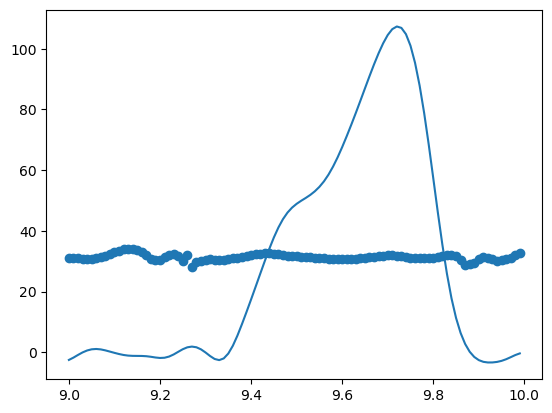

In [29]:
plt.figure()
#inp = np.cat((tsd[:,0].unsqueeze(1),trunk_j.unsqueeze(1),hip_j.unsqueeze(1),knee_j.unsqueeze(1),ankle_j.unsqueeze(1)), dim=1).type(dtype)
pred = model(torch.tensor(tsd[:,1:-1]).type(dtype))
plt.plot(tsd[:, 0],tsd[:, -1])
plt.scatter(tsd[:, 0],pred.squeeze().detach().numpy())

In [23]:
train_batches.__len__()

765

In [24]:
batch_size = 50
iters = x.shape[0]
startt = 0
endt = batch_size
bc = 0
for i in range(1):
    #    
    batch_Data = x[startt:endt].reshape(batch_size, 6, 20) # 6 is no of features
    startt += batch_size
    endt += batch_size
    bc += 1
    if endt > iters: 
        print("break: ", batch_Data.shape, endt, iters)
        break
    print(batch_Data.shape)
    #
    h = lstm(torch.Tensor(batch_Data))
    print(h.size(), h)
print("bc", bc)

NameError: name 'x' is not defined

In [ ]:
torch.hstack((torch.randn(5).unsqueeze(1), torch.randn(5).unsqueeze(1))).size()

torch.Size([5, 2])